In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm


# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# 自定义数据集类
class FaceDataset(Dataset):
    def __init__(self, data_file, raw_data_dir, transform=None):
        self.data_file = data_file
        self.raw_data_dir = raw_data_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        with open(self.data_file, 'r') as f:
            for line_number, line in enumerate(f, start=1):
                parts = line.strip().split()
                if len(parts) < 5:
                    print(f"Skipping incomplete line {line_number}: {line}")
                    continue  # 跳过不完整或错误的数据行

                try:
                    image_id = parts[0]
                    sex = parts[2].strip('()')
                    age = parts[4].strip('()')
                    race = parts[6].strip('()')
                    face = parts[8].strip('()')
                    samples.append((image_id, sex, age, race, face))
                except IndexError as e:
                    print(f"Skipping malformed line {line_number} due to error: {e}\nLine content: {line}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, sex, age, race, face = self.samples[idx]
        image_path = os.path.join(self.raw_data_dir, image_id)

        file_size_kb = os.path.getsize(image_path) / 1024

        if file_size_kb < 20:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
        else:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                img = img.resize((128, 128))
        if self.transform:
            img = self.transform(img)

        # 将类别标签转换为整数
        sex_label = {'male': 0, 'female': 1}.get(sex, -1)
        age_label = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}.get(age, -1)
        race_label = {'white': 0, 'yellow': 1, 'black': 2, 'hispanic': 0, 'asian': 1, 'other': 0}.get(race, -1)
        face_label = {'smiling': 0, 'serious': 1, 'funny': 2}.get(face, -1)

        labels = [sex_label, age_label, race_label, face_label]
        if any(label == -1 for label in labels):
            print(f"Invalid label in sample: {self.samples[idx]}")
            raise ValueError(f"Invalid label in sample: {self.samples[idx]}")

        return img, torch.tensor(labels, dtype=torch.long)


In [3]:
# 数据变换，包括数据增强
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 加载数据集
train_dataset = FaceDataset(data_file='../人脸图像识别/face/faceDR', raw_data_dir='../人脸图像识别/face/rawdata', transform=train_transform)
test_dataset = FaceDataset(data_file='../人脸图像识别/face/faceDS', raw_data_dir='../人脸图像识别/face/rawdata', transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Skipping incomplete line 6:  1228 (_missing descriptor)

Skipping incomplete line 10:  1232 (_missing descriptor)

Skipping incomplete line 586:  1808 (_missing descriptor)

Skipping incomplete line 834:  4056 (_missing descriptor)

Skipping incomplete line 913:  4135 (_missing descriptor)

Skipping incomplete line 914:  4136 (_missing descriptor)

Skipping incomplete line 1782:  5004 (_missing descriptor)



In [4]:
# 定义卷积神经网络模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 2)  # 性别
        self.fc3 = nn.Linear(256, 4)  # 年龄
        self.fc4 = nn.Linear(256, 3)  # 种族
        self.fc5 = nn.Linear(256, 3)  # 表情

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        sex_output = self.fc2(x)
        age_output = self.fc3(x)
        race_output = self.fc4(x)
        face_output = self.fc5(x)
        return sex_output, age_output, race_output, face_output

  2%|▏         | 1/50 [00:03<02:42,  3.32s/it]

Epoch [1/50], Loss: 2.7665


  4%|▍         | 2/50 [00:06<02:33,  3.20s/it]

Epoch [2/50], Loss: 2.4966


  6%|▌         | 3/50 [00:09<02:26,  3.11s/it]

Epoch [3/50], Loss: 2.2923


  8%|▊         | 4/50 [00:12<02:20,  3.05s/it]

Epoch [4/50], Loss: 2.1156


 10%|█         | 5/50 [00:15<02:15,  3.01s/it]

Epoch [5/50], Loss: 1.9654


 12%|█▏        | 6/50 [00:18<02:11,  2.98s/it]

Epoch [6/50], Loss: 1.8737


 14%|█▍        | 7/50 [00:21<02:07,  2.97s/it]

Epoch [7/50], Loss: 1.6744


 16%|█▌        | 8/50 [00:24<02:04,  2.96s/it]

Epoch [8/50], Loss: 1.5499


 18%|█▊        | 9/50 [00:27<02:02,  2.99s/it]

Epoch [9/50], Loss: 1.4424


 20%|██        | 10/50 [00:30<01:59,  2.98s/it]

Epoch [10/50], Loss: 1.3553


 22%|██▏       | 11/50 [00:33<01:56,  2.98s/it]

Epoch [11/50], Loss: 1.2736


 24%|██▍       | 12/50 [00:36<01:54,  3.02s/it]

Epoch [12/50], Loss: 1.2451


 26%|██▌       | 13/50 [00:39<01:52,  3.03s/it]

Epoch [13/50], Loss: 1.1851


 28%|██▊       | 14/50 [00:42<01:52,  3.13s/it]

Epoch [14/50], Loss: 1.1524


 30%|███       | 15/50 [00:45<01:51,  3.17s/it]

Epoch [15/50], Loss: 1.0292


 32%|███▏      | 16/50 [00:49<01:50,  3.26s/it]

Epoch [16/50], Loss: 0.9924


 34%|███▍      | 17/50 [00:52<01:50,  3.35s/it]

Epoch [17/50], Loss: 0.8970


 36%|███▌      | 18/50 [00:56<01:48,  3.40s/it]

Epoch [18/50], Loss: 0.8579


 38%|███▊      | 19/50 [00:59<01:43,  3.35s/it]

Epoch [19/50], Loss: 0.8602


 40%|████      | 20/50 [01:02<01:38,  3.30s/it]

Epoch [20/50], Loss: 0.7794


 42%|████▏     | 21/50 [01:06<01:34,  3.26s/it]

Epoch [21/50], Loss: 0.7252


 44%|████▍     | 22/50 [01:09<01:31,  3.26s/it]

Epoch [22/50], Loss: 0.6581


 46%|████▌     | 23/50 [01:12<01:26,  3.21s/it]

Epoch [23/50], Loss: 0.6462


 48%|████▊     | 24/50 [01:15<01:22,  3.18s/it]

Epoch [24/50], Loss: 0.5440


 50%|█████     | 25/50 [01:18<01:19,  3.16s/it]

Epoch [25/50], Loss: 0.5115


 52%|█████▏    | 26/50 [01:21<01:16,  3.17s/it]

Epoch [26/50], Loss: 0.5759


 54%|█████▍    | 27/50 [01:25<01:13,  3.18s/it]

Epoch [27/50], Loss: 0.4566


 56%|█████▌    | 28/50 [01:28<01:09,  3.17s/it]

Epoch [28/50], Loss: 0.4483


 58%|█████▊    | 29/50 [01:31<01:07,  3.21s/it]

Epoch [29/50], Loss: 0.3770


 60%|██████    | 30/50 [01:35<01:06,  3.32s/it]

Epoch [30/50], Loss: 0.3880


 62%|██████▏   | 31/50 [01:38<01:03,  3.34s/it]

Epoch [31/50], Loss: 0.3189


 64%|██████▍   | 32/50 [01:42<01:01,  3.44s/it]

Epoch [32/50], Loss: 0.3195


 66%|██████▌   | 33/50 [01:45<00:58,  3.42s/it]

Epoch [33/50], Loss: 0.2851


 68%|██████▊   | 34/50 [01:48<00:54,  3.42s/it]

Epoch [34/50], Loss: 0.2904


 70%|███████   | 35/50 [01:52<00:53,  3.56s/it]

Epoch [35/50], Loss: 0.2718


 72%|███████▏  | 36/50 [01:56<00:51,  3.66s/it]

Epoch [36/50], Loss: 0.1867


 74%|███████▍  | 37/50 [02:00<00:46,  3.55s/it]

Epoch [37/50], Loss: 0.1662


 76%|███████▌  | 38/50 [02:03<00:41,  3.45s/it]

Epoch [38/50], Loss: 0.1850


 78%|███████▊  | 39/50 [02:06<00:37,  3.38s/it]

Epoch [39/50], Loss: 0.2199


 80%|████████  | 40/50 [02:09<00:33,  3.32s/it]

Epoch [40/50], Loss: 0.1838


 82%|████████▏ | 41/50 [02:12<00:29,  3.33s/it]

Epoch [41/50], Loss: 0.1416


 84%|████████▍ | 42/50 [02:16<00:26,  3.37s/it]

Epoch [42/50], Loss: 0.1908


 86%|████████▌ | 43/50 [02:20<00:24,  3.44s/it]

Epoch [43/50], Loss: 0.1198


 88%|████████▊ | 44/50 [02:23<00:20,  3.48s/it]

Epoch [44/50], Loss: 0.1091


 90%|█████████ | 45/50 [02:27<00:17,  3.54s/it]

Epoch [45/50], Loss: 0.1036


 92%|█████████▏| 46/50 [02:30<00:14,  3.53s/it]

Epoch [46/50], Loss: 0.1787


 94%|█████████▍| 47/50 [02:34<00:10,  3.46s/it]

Epoch [47/50], Loss: 0.1301


 96%|█████████▌| 48/50 [02:37<00:06,  3.44s/it]

Epoch [48/50], Loss: 0.0898


 98%|█████████▊| 49/50 [02:40<00:03,  3.46s/it]

Epoch [49/50], Loss: 0.0707


100%|██████████| 50/50 [02:44<00:00,  3.29s/it]

Epoch [50/50], Loss: 0.0796


Accuracy of the model on the test images: 82.60%
Accuracy of the model on the test images for each category:
male Accuracy: 82.85%
female Accuracy: 77.75%
Accuracy of the model on the test images for each category:
child Accuracy: 19.12%
teen Accuracy: 7.23%
adult Accuracy: 99.02%
senior Accuracy: 20.87%
Accuracy of the model on the test images for each category:
white Accuracy: 97.44%
yellow Accuracy: 26.92%
black Accuracy: 10.44%
Accuracy of the model on the test images for each category:
smiling Accuracy: 76.20%
serious Accuracy: 79.49%
funny Accuracy: 4.76%


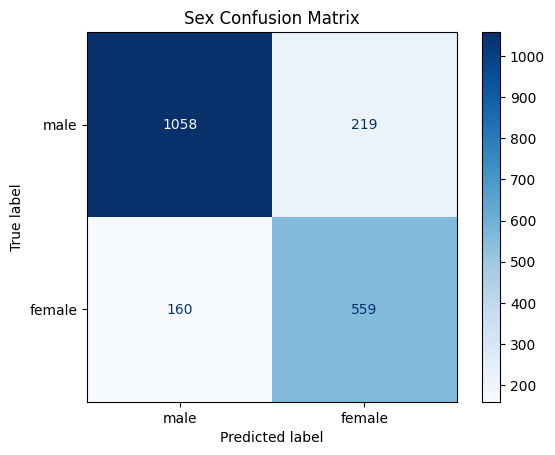

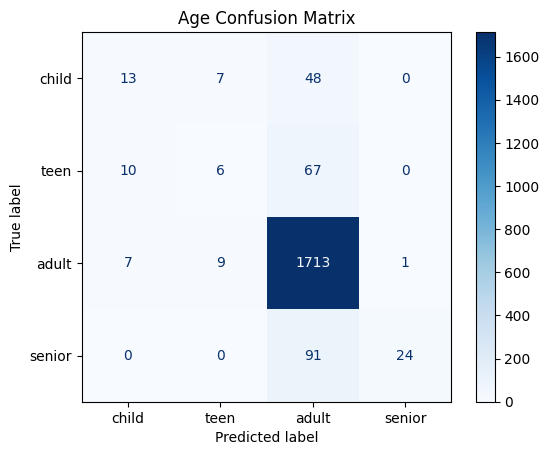

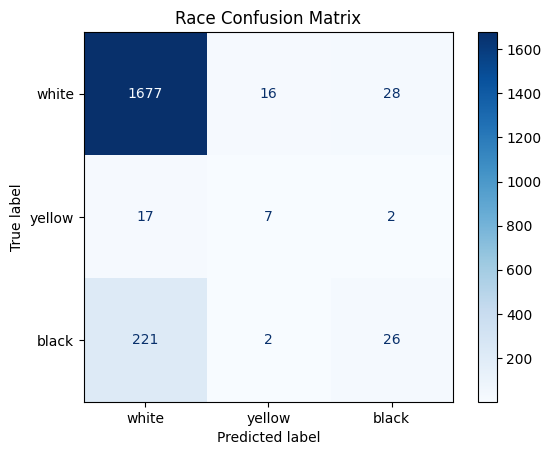

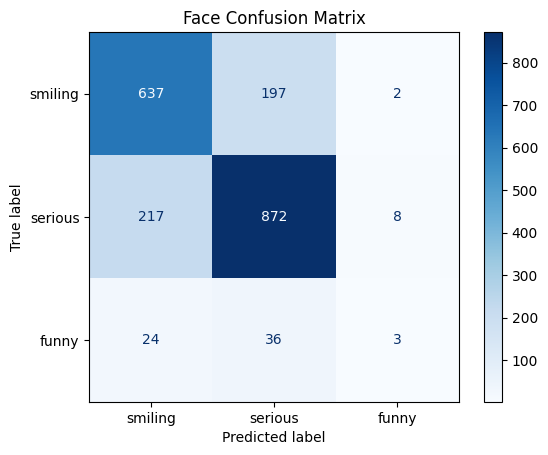

In [5]:
# 初始化模型、损失函数和优化器
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# 训练模型
num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        loss = criterion(sex_outputs, labels[:, 0]) + \
               criterion(age_outputs, labels[:, 1]) + \
               criterion(race_outputs, labels[:, 2]) + \
               criterion(face_outputs, labels[:, 3])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 评估模型
model.eval()
total = 0
correct = 0

# 存储所有真实标签和预测标签
true_labels = {'sex': [], 'age': [], 'race': [], 'face': []}
pred_labels = {'sex': [], 'age': [], 'race': [], 'face': []}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        _, predicted_sex = torch.max(sex_outputs, 1)
        _, predicted_age = torch.max(age_outputs, 1)
        _, predicted_race = torch.max(race_outputs, 1)
        _, predicted_face = torch.max(face_outputs, 1)

        true_labels['sex'].extend(labels[:, 0].cpu().numpy())
        pred_labels['sex'].extend(predicted_sex.cpu().numpy())
        true_labels['age'].extend(labels[:, 1].cpu().numpy())
        pred_labels['age'].extend(predicted_age.cpu().numpy())
        true_labels['race'].extend(labels[:, 2].cpu().numpy())
        pred_labels['race'].extend(predicted_race.cpu().numpy())
        true_labels['face'].extend(labels[:, 3].cpu().numpy())
        pred_labels['face'].extend(predicted_face.cpu().numpy())

        total += labels.size(0)

        correct += ((predicted_sex == labels[:, 0]).sum().item() +
                    (predicted_age == labels[:, 1]).sum().item() +
                    (predicted_race == labels[:, 2]).sum().item() +
                    (predicted_face == labels[:, 3]).sum().item()) / 4

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

# 计算并打印各个类别的准确率
def calculate_accuracy(true_labels, pred_labels, num_classes, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    row_sums = cm.sum(axis=1)
    accuracies = np.zeros(num_classes)
    for i in range(num_classes):
        if row_sums[i] > 0:
            accuracies[i] = cm[i, i] / row_sums[i]
    print(f'Accuracy of the model on the test images for each category:')
    for i, acc in enumerate(accuracies):
        print(f'{class_names[i]} Accuracy: {100 * acc:.2f}%')

calculate_accuracy(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'])
calculate_accuracy(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'])
calculate_accuracy(true_labels['race'], pred_labels['race'], 3, ['white', 'yellow', 'black'])
calculate_accuracy(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'])

# 绘制混淆矩阵
def plot_confusion_matrix(true_labels, pred_labels, num_classes, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'], 'Sex Confusion Matrix')
plot_confusion_matrix(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'], 'Age Confusion Matrix')
plot_confusion_matrix(true_labels['race'], pred_labels['race'], 3, ['white', 'yellow', 'black'], 'Race Confusion Matrix')
plot_confusion_matrix(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'], 'Face Confusion Matrix')



